# Redes Neurais

No exemplo abaixo é mostrado como fazer o treinamento de uma rede neural bem simples para classificar o dataset MNIST, o dataset MNIST é um conjunto de dígitos escritos a mão de 0 a 9.

In [16]:
import os
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

## carrega o dataset mnist
root = './data'
if not os.path.exists(root):
    os.mkdir(root)
    
# function utilizado para fazer a normalização
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

# carrega o dataset MNIST, caso esse não exista, faz o download
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)

batch_size = 100

# instancia o dataloader utilizando o dataset MNIST
train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)

print (' -- total trainning batch number: {0}'.format(len(train_loader)))

 -- total trainning batch number: 600
 -- total testing batch number: 100


`dset.MNIST` carrega o dataset MNIST, caso esse ainda não exista, esse método faz o download. O argumento trans é um function utilizado para normalizar os dados do MNIST.
`DataLoader` instância o dataload que será utilizado durante o treinamento

In [25]:
# definição do modelo
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 300)
        self.fc2 = nn.Linear(300, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x


model = MyNet()
print(model)

MyNet(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
)


Para definir o seu modelo no PyTorch você deve criar uma classe que herda de `nn.Module`. O design do PyTorch é fortemente baseado em orientação a objetos.
A classe do seu modelo precisa implementar o método  `forward`, assim o esqueleto da classe que representa o nosso modelo é:
```
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        
    def forward(self, x):
        pass
```
No método `__ini__` são instanciados os objetos utilizados no modelo, nesse caso as camadas que serão utilizadas no modelo. No nosso caso serão utilizadas 3 camadas lineares.

`torch.nn.Linear(in_features, out_features, bias=True)` essa é a assinatura do objeto Linear, o primeiro argumento é número de features de entrada, o segundo é o número de features de saída e o terceiro especifica se terá ou não bias. Como sabemos o tamanho das imagens do MNIST é 28x28 pixels monocromáticos, ou seja, apenas em tons de cinza.

O método `forward` é onde essas camadas são conectadas. Uma atenção bem grande deve ser dada às conexões das camadas, o argumento `x` representa a entrada do modelo, é por ele que irá fluir o nosso tensor de entrada.

`x = x.view(-1, 28*28)`: O método `view` modifica o shape do tensor, e no caso o argumento -1 diz para o método que nós não sabemos quantas linhas tem o nosso tensor, note que apenas um parâmetro pode ser -1 no método `view`.

As próximas linhas conectam uma camada na outra, algo que pode gerar alguma confusão é o tipo do parâmetro `x`.
`torch::Tensor forward(torch::Tensor x)` Essa é a assinatura da API do PyTorch em C++, `forward` recebe e retorna um tensor, portanto, funções como `F.relu` também retornam um tensor.

O fato das camadas como Linear serem definidos no construtor, enquanto a relu ser apenas uma função que é conectada no método `forward`, se deve ao fato que Linear possui parâmetros (pesos), e não apenas uma função matemática que modifica o tensor de entrada como é o caso das funções de ativação.

In [26]:
device = torch.device("cuda" if use_cuda else "cpu")

# instância o algoritmo de otimização SGD para atualizar os parâmetros do nosso modelo
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# instância a função de perda
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    # itera sobre o data loader para gerar lotes do conjunto de dados
    for batch_idx, (x, target) in enumerate(train_loader):
        # reseta os gradientes
        optimizer.zero_grad()
        # transfere o tensor para o device utilizado
        x, target = x.to(device), target.to(device)
        # executa o modelo nos dados de entrada
        out = model(x)
        # calcula o valor de perda para comparar com o nosso modelo
        loss = criterion(out, target)
        # calcula o gradiente da perda calculada no nosso modelo
        loss.backward()
        # atualiza os parâmetros do nosso modelo baseado no cálculo do gradiente
        optimizer.step()
        # imprime a época, o batch e a perda periodicamente a cada 100 batches         
        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print ('==>>> epoch: {0}, batch index: {1}, train loss: {2}'.format(
                epoch, batch_idx+1, loss.item()))

==>>> epoch: 0, batch index: 100, train loss: 1.9767781496047974
==>>> epoch: 0, batch index: 200, train loss: 0.5577573776245117
==>>> epoch: 0, batch index: 300, train loss: 0.3963330090045929
==>>> epoch: 0, batch index: 400, train loss: 0.21971210837364197
==>>> epoch: 0, batch index: 500, train loss: 0.25142425298690796
==>>> epoch: 0, batch index: 600, train loss: 0.27990201115608215
==>>> epoch: 1, batch index: 100, train loss: 0.2895001769065857
==>>> epoch: 1, batch index: 200, train loss: 0.15145011246204376
==>>> epoch: 1, batch index: 300, train loss: 0.2328670471906662
==>>> epoch: 1, batch index: 400, train loss: 0.24531914293766022
==>>> epoch: 1, batch index: 500, train loss: 0.1771671175956726
==>>> epoch: 1, batch index: 600, train loss: 0.15539273619651794
==>>> epoch: 2, batch index: 100, train loss: 0.37194594740867615
==>>> epoch: 2, batch index: 200, train loss: 0.12438665330410004
==>>> epoch: 2, batch index: 300, train loss: 0.12461578100919724
==>>> epoch: 2, 

Embora possa ter variações, esse é o formato básico padrão do loop de treinamento utilizado pelo PyTorch. Os comentários em cada linha diz que cada chamada faz.

O loop começa com uma chamada de `zero_grad` para zerar o gradiente, isso é necessário pois o PyTorch acumula o gradiente, isso é útil em redes recorrentes e em vários outros casos, então, se não é esse o nosso caso, temos que zerar o gradiente.
Os próximos passos é basicamente calcular a predição para os dados de entrada utilizando com os parâmetros que temos no momento, e comparar com a predição anotada, então precisamos calcular o gradiente utilizando a função de otimização escolhida, que no nosso caso foi SGD, e então atualizamos os parâmetros do nosso modelo utilizando o gradiente calculado.

number:  4


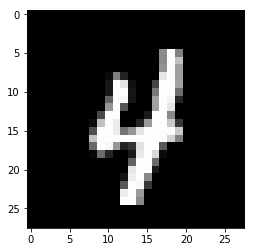

In [56]:
# importa o pacote para plotar imagens
import matplotlib.pyplot as plt

# a cada execução pega a próxima imagem e plota essa imagem
(example_data, _) = next(iter(train_loader))
fig = plt.figure()
plt.imshow(example_data[0][0], cmap='gray', interpolation='none')
fig

# faz a predição da imagem no modelo
out = model(example_data[0][0])

# pega o máximo valor do tensor e o seu indice
values, indices = torch.max(out, 1)

# imprime o indice que corresponde exatamente ao número
print("number: ", int(indices[0]))

Esse é um exemplo básico de como fazer a predição por um modelo treinado no PyTorch. É claro que na prática você nunca vai querer prever um dado que fez parte do conjunto de treinamento, mas para demonstrar como a coisa funciona, apesar de totalmente errado conceitualmente, por enquanto serve.